In [1]:
%load_ext autoreload
%autoreload 2 
import sys
sys.path.insert(0, '../../')
sys.path.insert(0, '../preprocessing/')
sys.path.insert(0, '../')

import ESM_utils as esm
import os
import glob 
import shutil 
import re
#import plotly.graph_objects as go

import nibabel as nib

import create_pet_probability_matrix

import pandas as pd
import numpy as np
import nilearn.plotting as plotting
import itertools
import matplotlib.colors as colors
import seaborn as sns

import matplotlib.pyplot as plt
import math
from statannot import add_stat_annotation

from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from nilearn import input_data, image

In [2]:
def intersection(lst1, lst2): 
  
    # Use of hybrid method 
    temp = set(lst2) 
    lst3 = [value for value in lst1 if value in temp] 
    return lst3 

In [3]:
clinical_df = pd.read_csv("../../data/DIAN/participant_metadata/CLINICAL_D1801.csv")
genetic_df = pd.read_csv("../../data/DIAN/participant_metadata/GENETIC_D1801.csv")
pib_df = pd.read_csv("../../data/DIAN/participant_metadata/pib_D1801.csv")

/data1/llevitis/miniconda3/envs/clinicaEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (139,152,512,991,997,999,1001,1003,1005,1013,1015,1019,1021,1039,1041,1043,1113,1117) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
def add_metadata_to_amyloid_df(df, genetic_df, clinical_df):
    for sub in df.index: 
        sub_df = df[df.index == sub]
        visits = list(sub_df.visit)
        mutation = genetic_df[(genetic_df.IMAGID == sub)].Mutation.values[0]
        for i in range(0, len(visits)):
            visit = visits[i]
            dian_eyo = clinical_df[(clinical_df.IMAGID == sub) & (clinical_df.visit == visit)].DIAN_EYO.values
            age = clinical_df[(clinical_df.IMAGID == sub) & (clinical_df.visit == visit)].VISITAGEc.values
            if len(dian_eyo) == 0:
                print(sub + " " + visit)
            if len(dian_eyo) > 0:
                df.loc[(df.index == sub) & (df.visit == visit), "DIAN_EYO"] = dian_eyo[0]
                df.loc[(df.index == sub) & (df.visit == visit), "VISITAGEc"] = age[0]
                df.loc[(df.index == sub) & (df.visit == visit), "visitNumber"] = i + 1
                df.loc[(df.index == sub) & (df.visit == visit), "Mutation"] = mutation
    return df

In [7]:
# load all matrices 
dian_pup_voxelwise_ecdf_v00 = pd.read_csv("../../data/DIAN/pet_probability_matrices/DIAN_PUP_coregistered_voxelwise_ecdf_orig_method_ref-brainstem_75perc_v00.csv", index_col=0)
dian_pup_voxelwise_ecdf_v00.loc[:, 'visit'] = "v00"
dian_pup_voxelwise_ecdf_v01 = pd.read_csv("../../data/DIAN/pet_probability_matrices/DIAN_PUP_coregistered_voxelwise_ecdf_orig_method_ref-brainstem_75perc_v01.csv", index_col=0)
dian_pup_voxelwise_ecdf_v01.loc[:, 'visit'] = "v01"
dian_pup_voxelwise_ecdf_v02 = pd.read_csv("../../data/DIAN/pet_probability_matrices/DIAN_PUP_coregistered_voxelwise_ecdf_orig_method_ref-brainstem_75perc_v02.csv", index_col=0)
dian_pup_voxelwise_ecdf_v02.loc[:, 'visit'] = "v02"
dian_pup_voxelwise_ecdf_v03 = pd.read_csv("../../data/DIAN/pet_probability_matrices/DIAN_PUP_coregistered_voxelwise_ecdf_orig_method_ref-brainstem_75perc_v03.csv", index_col=0)
dian_pup_voxelwise_ecdf_v03.loc[:, 'visit'] = "v03"
dian_pup_voxelwise_ecdf_v04 = pd.read_csv("../../data/DIAN/pet_probability_matrices/DIAN_PUP_coregistered_voxelwise_ecdf_orig_method_ref-brainstem_75perc_v04.csv", index_col=0)
dian_pup_voxelwise_ecdf_v04.loc[:, 'visit'] = "v04"
dian_pup_voxelwise_ecdf_v05 = pd.read_csv("../../data/DIAN/pet_probability_matrices/DIAN_PUP_coregistered_voxelwise_ecdf_orig_method_ref-brainstem_75perc_v05.csv", index_col=0)
dian_pup_voxelwise_ecdf_v05.loc[:, 'visit'] = "v05"

### drop BS2VBS at v03 & "U482R7" at v00 as they were not fully processed with PUP
dian_pup_voxelwise_ecdf_v00 = dian_pup_voxelwise_ecdf_v00[dian_pup_voxelwise_ecdf_v00.index != "U482R7"]
dian_pup_voxelwise_ecdf_v03 = dian_pup_voxelwise_ecdf_v03[dian_pup_voxelwise_ecdf_v03.index != "BS2VBS"]

# concatenate visit label specific matrices
dian_pup_voxelwise_ecdf_all_visits = pd.concat([dian_pup_voxelwise_ecdf_v00,
                                                dian_pup_voxelwise_ecdf_v01, 
                                                dian_pup_voxelwise_ecdf_v02, 
                                                dian_pup_voxelwise_ecdf_v03,
                                                dian_pup_voxelwise_ecdf_v04,
                                                dian_pup_voxelwise_ecdf_v05])

dian_pup_voxelwise_ecdf_all_visits = add_metadata_to_amyloid_df(dian_pup_voxelwise_ecdf_all_visits, genetic_df, clinical_df)

In [8]:
roi_cols = dian_pup_voxelwise_ecdf_all_visits.columns[0:78]

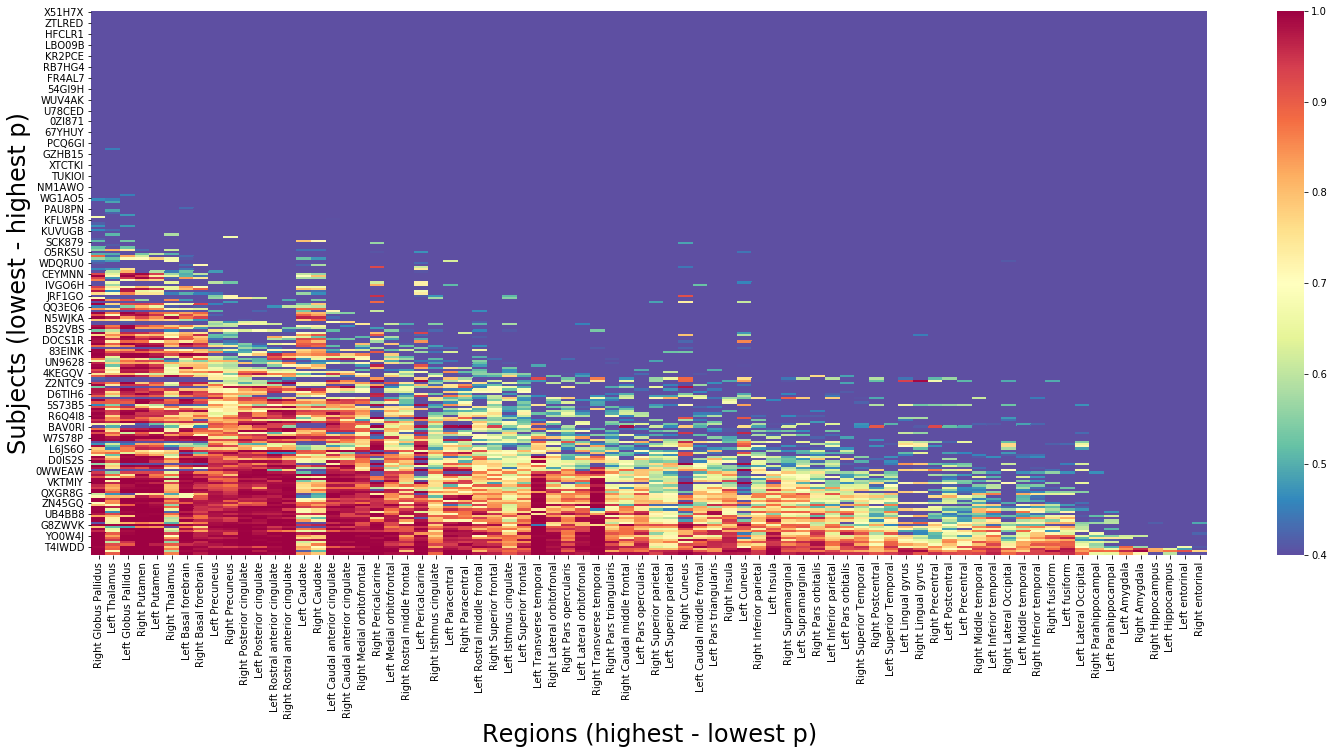

In [15]:
first_timepoint_heatmap = esm.Plot_Probabilites(dian_pup_voxelwise_ecdf_all_visits[
                                               (dian_pup_voxelwise_ecdf_all_visits.visitNumber == 1) &\
                                               (dian_pup_voxelwise_ecdf_all_visits.Mutation == 1)
                                              ][roi_cols], 
                                                figsize=(25,10), 
                                                cmap="Spectral_r",
                                               vmin=0.4)

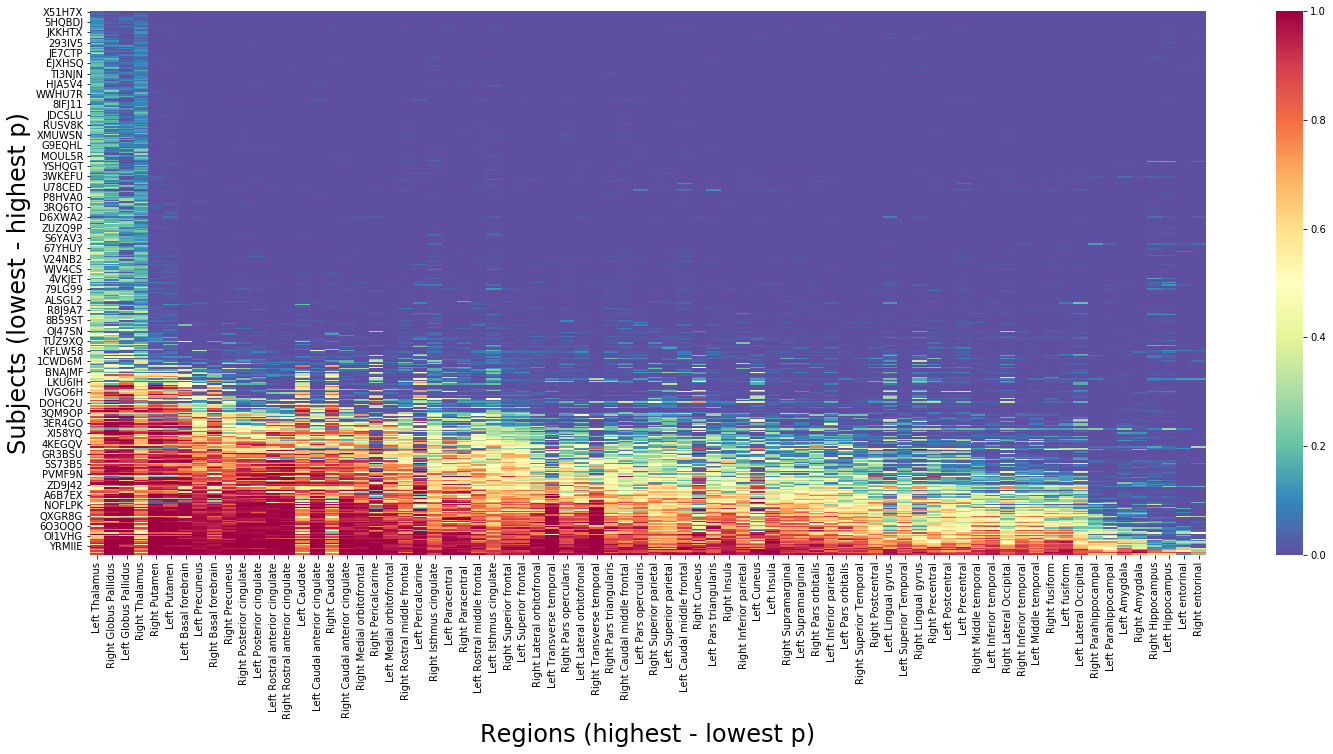

In [10]:
first_timepoint_heatmap = esm.Plot_Probabilites(dian_pup_voxelwise_ecdf_all_visits[(dian_pup_voxelwise_ecdf_all_visits.visitNumber == 1)][roi_cols], figsize=(25,10), cmap="Spectral_r")

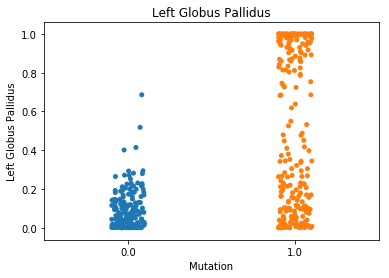

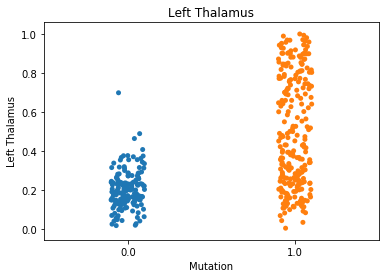

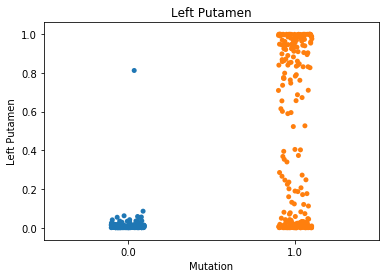

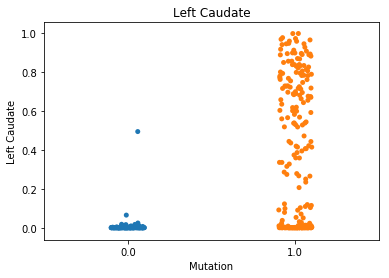

In [14]:
for roi in ["Left Globus Pallidus", "Left Thalamus", "Left Putamen", "Left Caudate"]:
    sns.stripplot(x="Mutation", y=roi,
            data=dian_pup_voxelwise_ecdf_all_visits[dian_pup_voxelwise_ecdf_all_visits.visitNumber == 1])
    plt.title(roi)
    plt.show()